
#Consignes

projet : https://openclassrooms.com/fr/paths/164/projects/631/assignment

* ## Votre mission

Votre mission est de réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.


> Vous analyserez le jeu de données en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.



* ## Livrables


    Un notebook (ou des fichiers .py) contenant les fonctions permettant le prétraitement des données textes et images ainsi que les résultats du clustering (en y incluant des représentations graphiques au besoin).
    Un support de présentation qui présente la démarche et les résultats du clustering.




# Importations et inspection

## Importation des modules

In [1]:
#%%flake8  # checking PEP8 compliance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# increase the maximum number of columns to display
pd.set_option("display.max_columns", 1000)  # Maximum number of columns

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive/')
  IN_COLAB = True
except:
  IN_COLAB = False

Mounted at /content/drive/


In [3]:
!git clone https://github.com/SmadjaPaul/Library_DS.git
#%load work_dir + Library_DS/functions_p5.py
!git -C "Library_DS" pull
%load "Library_DS/functions_p6.py"
import Library_DS.functions_p6 as functions_p6


Cloning into 'Library_DS'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 62 (delta 17), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (62/62), done.
Already up to date.


In [4]:
# %%flake8  # checking PEP8 compliance

import random
from random import randrange

# Set random integer (seed)
seed = random.randrange(1000)

# Initialize the seed of pseudo-random generator
random.seed(seed)
print("Seed value: ", seed)

Seed value:  638


# Extraction du jeu de données déjà constitué

## Importation du fichier .csv

In [5]:
# %%flake8  # checking PEP8 compliance
import os
from IPython.display import display

if IN_COLAB == True:
  dir_name = "/content/drive/My Drive/OPC/perso/OPC_P6_conso/data/"
  save_dir = "/content/drive/My Drive/OPC/perso/OPC_P6_conso/data/save/"
else:
  dir_name = 'data/'
  save_dir = "data/save/"
  
file_name = 'Flipkart/flipkart_com-ecommerce_sample_1050.csv'
file_path = dir_name + file_name
data = pd.read_csv(file_path)
data.shape

(1050, 15)

In [6]:
data.head(2).T

,0,1
uniq_id,55b85ea15a1536d46b7190ad6fff8ce7,7b72c92c2f6c40268628ec5f14c6d590
crawl_timestamp,2016-04-30 03:22:56 +0000,2016-04-30 03:22:56 +0000
product_url,http://www.flipkart.com/elegance-polyester-mul...,http://www.flipkart.com/sathiyas-cotton-bath-t...
product_name,Elegance Polyester Multicolor Abstract Eyelet ...,Sathiyas Cotton Bath Towel
product_category_tree,"[""Home Furnishing >> Curtains & Accessories >>...","[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
pid,CRNEG7BKMFFYHQ8Z,BTWEGFZHGBXPHZUH
retail_price,1899,600
discounted_price,899,449
image,55b85ea15a1536d46b7190ad6fff8ce7.jpg,7b72c92c2f6c40268628ec5f14c6d590.jpg
is_FK_Advantage_product,False,False


In [7]:
data.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

## Vérification de l'intégrité des données

### Données dupliquées

In [8]:
data.duplicated(subset=['uniq_id']).any()

False

### Données manquantes

In [9]:
functions_p6.global_filling_rate(data)

DataFrame has 1050 rows and 15 columns.

Global filling rate of the DataFrame: 97.83%
Missing values in the DataFrame: 341 (2.17%)

Number of rows with missing values: 340 (32.38%)
Number of columns with missing values: 4 (26.67%)


In [10]:
#-----------------------------------------------------------------------
def columns_filling_rate(dataframe, columns='all', missing_only=False):
    """Calculate and displays the filling rate for
    a particular column in a pd.DataFrame."""
    
    # Importations
    import pandas as pd
    import numpy as np
    
    # If 'feature' is not specified
    if columns == 'all':
        columns = dataframe.columns
        
    
    # initialization of the results DataFrame
    results = pd.DataFrame(columns=['nb_values', 'missing_values', 'filling_rate'])
        
    # for each feature
    for column in columns:

        # Count of the values on each column
        values_count = dataframe[column].count()
        
        # Computing missing values
        nb_rows = dataframe.shape[0]
        missing_values = nb_rows - values_count

        # Computing filling rates
        filling_rate = values_count / nb_rows
        if missing_only and missing_values == 0:
            filling_rate = np.nan
        
        # Adding a row in the results' dataframe
        results.loc[column] = [values_count, missing_values, filling_rate]

    # Sorting the features by number of missing_values
    results = results.dropna(subset=['filling_rate'])
    results = results.sort_values('filling_rate')
    
    if results.empty == False:
        return results
    else:
        print("No missing value.")

In [11]:
columns_filling_rate(data, missing_only=True)

,nb_values,missing_values,filling_rate
brand,712.0,338.0,0.678095
retail_price,1049.0,1.0,0.999048
discounted_price,1049.0,1.0,0.999048
product_specifications,1049.0,1.0,0.999048


In [12]:
data['product_specifications'].loc[1]

'{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {"key"=>"Size", "value"=>"Mediam"}, {"key"=>"Length", "value"=>"30 inch"}, {"key"=>"Width", "value"=>"60 inch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"3"}, {"key"=>"Sales Package", "value"=>"3 Bath Towel"}]}'

In [13]:
data = data.drop(columns=[
    'crawl_timestamp',
    'product_url',
    'pid',
    'retail_price',
    'discounted_price',
    'is_FK_Advantage_product',
    'product_rating',
    'overall_rating',
    'product_specifications',
])

data.head(3).T

,0,1,2
uniq_id,55b85ea15a1536d46b7190ad6fff8ce7,7b72c92c2f6c40268628ec5f14c6d590,64d5d4a258243731dc7bbb1eef49ad74
product_name,Elegance Polyester Multicolor Abstract Eyelet ...,Sathiyas Cotton Bath Towel,Eurospa Cotton Terry Face Towel Set
product_category_tree,"[""Home Furnishing >> Curtains & Accessories >>...","[""Baby Care >> Baby Bath & Skin >> Baby Bath T...","[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
image,55b85ea15a1536d46b7190ad6fff8ce7.jpg,7b72c92c2f6c40268628ec5f14c6d590.jpg,64d5d4a258243731dc7bbb1eef49ad74.jpg
description,Key Features of Elegance Polyester Multicolor ...,Specifications of Sathiyas Cotton Bath Towel (...,Key Features of Eurospa Cotton Terry Face Towe...
brand,Elegance,Sathiyas,Eurospa


In [14]:
functions_p6.global_filling_rate(data)

DataFrame has 1050 rows and 6 columns.

Global filling rate of the DataFrame: 94.63%
Missing values in the DataFrame: 338 (5.37%)

Number of rows with missing values: 338 (32.19%)
Number of columns with missing values: 1 (16.67%)


## Étude des catégories de produits

### Récupération des catégories à partir de 'product_category_tree'

In [15]:
# Definition of a function to apply or map
def get_categories_from_series(series):
    
    # --------------------------------------
    # Function to get the 3 first categories
    def get_categories_from_cell(cell):
        # Remove unwanted chars
        product_category_tree = cell.strip('[]"')

        # Get (at most) the 3 first categories of the category tree
        product_categories_list = product_category_tree.split(" >> ")
        
        # Initialization
        categories = pd.Series()
        
        # for each category, add a row
        for i in range(min(3, len(product_categories_list))):
            categories["cat_{}".format(i+1)] = product_categories_list[i]
        
        # return pd.Series with 3 rows
        return categories

    # ------------------------------------------------
    # Proceed to the split
    categories_df = series.apply(get_categories_from_cell).fillna("")

    # Return the frequency_encoding pd.DataFrame
    return categories_df

categories_df = get_categories_from_series(data['product_category_tree'])


# Add the columns of categories to the data DataFrame
data = pd.concat(
    [data, categories_df],
    sort=False,
    axis=1
)

# Display results
data.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,uniq_id,product_name,product_category_tree,image,description,brand,cat_1,cat_2,cat_3
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care,Baby Bath & Skin,Baby Bath Towels


### Étude du remplissage des nouvelles variables 'cat_1', 'cat_2', 'cat_3'

In [16]:
functions_p6.global_filling_rate(data[['cat_1', 'cat_2', 'cat_3']])

DataFrame has 1050 rows and 3 columns.

Global filling rate of the DataFrame: 100.00%
Missing values in the DataFrame: 0 (0.00%)

Number of rows with missing values: 0 (0.00%)
Number of columns with missing values: 0 (0.00%)


### Étude des effectifs des catégories de produit

There are 7 categories at 1st level.


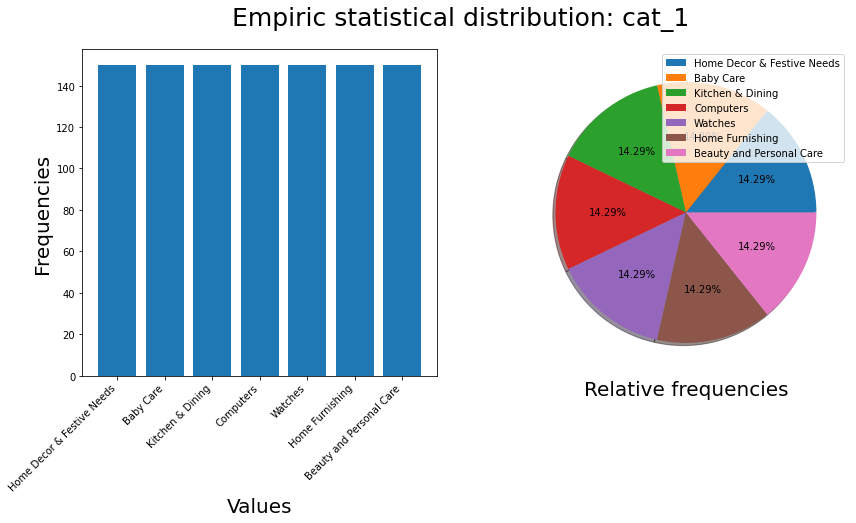

In [17]:
nb_cat1 = data['cat_1'].nunique()
print('There are {} categories at 1st level.'.format(nb_cat1))

fig = functions_p6.categorical_distribution(data['cat_1'])
fig.savefig(save_dir + 'plot/main_categories.png')

In [18]:
def plot_pie(feature_series):
    # importing libraries
    import matplotlib.pyplot as plt

    # Setting the data to plot
    x=feature_series[feature_series.notnull()]
    labels = list(x.value_counts().sort_values(ascending=False).index.astype(str))
    frequencies = x.value_counts().sort_values(ascending=False)

    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))

    # Main graphical properties of the second subplot (pieplot)
    plt.xlabel("Relative frequencies \n{}".format(feature_series.name), fontsize=20)

    # plotting the plots
    plt.pie(frequencies,
                # autopct='%1.2f%%',
                # shadow=True,
                  )

    #plt.legend(labels, loc='upper right', bbox_to_anchor=(1.5, 1.1))
    plt.show()
    return fig

There are 62 categories at 2nd level.


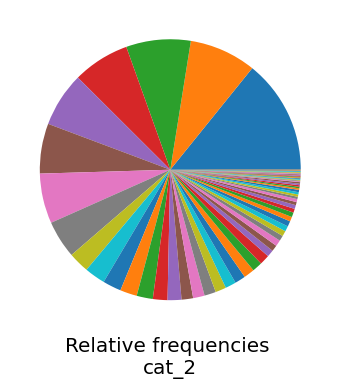

In [19]:
nb_cat2 = data['cat_2'].nunique()
print('There are {} categories at 2nd level.'.format(nb_cat2))

# displays the pie chart for distribution
fig = plot_pie(data['cat_2'])
fig.savefig(save_dir +'plot/cat_2.png')

There are 242 categories at 3rd level.


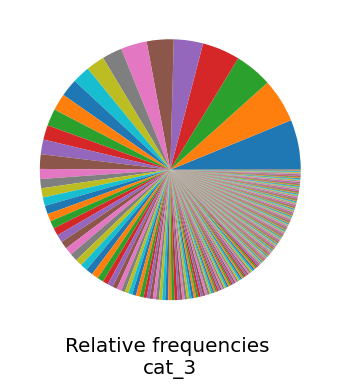

In [20]:
nb_cat3 = data['cat_3'].nunique()
print('There are {} categories at 3rd level.'.format(nb_cat3))

# displays the pie chart for distribution
fig = plot_pie(data['cat_3'])
fig.savefig(save_dir +'plot/cat_3.png')

# Analyse du jeu de données

In [21]:
# imputation of the missing 'brand' field by ''
data['brand'] = data['brand'].fillna('')

In [22]:
# Mixing product name, description and brand into a new feature
data['descriptions'] = data['product_name'] + ' ' + data['description'] + ' ' + data['brand']

In [23]:
data['descriptions'].iloc[0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

In [24]:
# Aggregate all the descriptions together
corpus = data['descriptions'].str.cat(sep=' ')

# Get the list of words
list_words = corpus.split()
print("Number of words: {}".format(len(list_words)))
print("Number of unique words: {}".format(len(set(list_words))))

Number of words: 88668
Number of unique words: 9593


In [25]:
corpus

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

In [26]:
# Sampling
#data = data.sample(n=100, random_state=None)

# Extraction de variables à partir des données textuelles

## Option 1 : encodage tf-idf

Le tf-idf (*term frequency-inverse document frequency*) est défini par :


* $\mathrm{tf}(t, d)$: *term frequency (default: natural)*: nombre d'occurence du terme *t* dans un document *d*

* $\mathrm{df}(t)$: *document frequency*: nombre de documents dans le corpus qui contiennent le terme *t*

* $\mathrm{idf}(t)$: *inverse document frequency*: $\mathrm{idf}(t) = log{\frac{n}{\mathrm{df(t)}}} + 1$
    * *n*: nombre total de documents dans le corpus


* $\mathrm{tf\_idf}(t, d)$: *term frequency-inverse document frequency*: $ \mathrm{tf\_idf}(t, d) = \mathrm{tf}(t, d) · \mathrm{idf}(t)$

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instanciation of the tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words='english',
    analyzer='word',
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 1),
)

# Application of the tf-idf vectorizer
corpus = data['descriptions']
X = tfidf_vectorizer.fit_transform(corpus)

# Conversion to a dense array for later use
X_dense = X.todense()

print('Size of the vocabulary: {}'.format(len(list(tfidf_vectorizer.vocabulary_))))
print('Number of stop words: {}'.format(len(tfidf_vectorizer.stop_words_)))

Size of the vocabulary: 2443
Number of stop words: 3399


In [28]:
import operator

# sorting vectorizer.vocabulary_ by feature indices
sorted_voc = sorted(tfidf_vectorizer.vocabulary_.items(), key=operator.itemgetter(1))

# get the sorted list words from vocabulary
sorted_voc = [ word for (word, word_indice) in sorted_voc ]

# recreate pd.DataFrame with vocabulary
text_TFIDF = pd.DataFrame(X_dense, columns=sorted_voc)
text_TFIDF.columns = ['bow_' + str(col) for col in text_TFIDF.columns]

# display first rows of the tf-idf vectorization
text_TFIDF.head()

,bow_001,bow_005,bow_01,bow_03,bow_04,bow_05tg,bow_06,bow_085,bow_099,bow_10,bow_100,bow_1000,bow_1001,bow_101,bow_104,bow_1049,bow_107,bow_1099,bow_11,bow_110,bow_1100,bow_112,bow_1149,bow_1150,bow_1199,bow_12,bow_120,bow_121,bow_122,bow_125,bow_1290,bow_1299,bow_13,bow_1333,bow_1350,bow_138,bow_1395,bow_14,bow_140,bow_1449,bow_145,bow_147,bow_149,bow_1499,bow_15,bow_150,bow_1500,bow_150ml,bow_152,bow_154,bow_1599,bow_16,bow_160,bow_165,bow_166,bow_169,bow_1699,bow_17,bow_170,bow_1700,bow_1749,bow_175,bow_1790,bow_1799,bow_18,bow_180,bow_1800,bow_189,bow_19,bow_190,bow_195,bow_196,bow_1979,bow_199,bow_1tb,bow_1year,bow_20,bow_200,bow_2000,bow_2008,bow_200gm,bow_21,bow_210,bow_213,bow_218,bow_219,bow_2199,bow_22,bow_220,bow_225,bow_2250,bow_228,bow_23,bow_230,bow_24,bow_240,bow_249,bow_2499,bow_25,bow_250,bow_259,bow_26,bow_265,bow_269,bow_26cm,bow_27,bow_270,bow_274,bow_275,bow_28,bow_280,bow_285,bow_29,bow_290,bow_295,bow_299,bow_2gb,bow_2w,bow_30,bow_300,bow_3000,bow_300ml,bow_301,bow_305,bow_309,bow_31,bow_310,bow_319,bow_32,bow_320,bow_325,bow_329,bow_32gb,bow_33,bow_330,bow_34,bow_340,bow_349,bow_35,bow_350,bow_355,bow_356,bow_36,bow_360,bow_365,bow_37,bow_370,bow_38,bow_380,bow_385,bow_389,bow_39,bow_390,bow_399,bow_3999,bow_3d,bow_40,bow_400,bow_42,bow_425,bow_43,bow_449,bow_45,bow_450,bow_47,bow_48,bow_480,bow_489,bow_499,bow_4995,bow_4999,bow_4gb,bow_4mm,bow_50,bow_500,bow_505,bow_51,bow_520,bow_529,bow_53,bow_549,bow_55,bow_550,bow_56,bow_569,bow_570,bow_58,bow_580,bow_589,bow_59,bow_590,bow_594,bow_595,bow_599,bow_5999,bow_5cms,bow_5mm,bow_5th,bow_5v,bow_60,bow_600,bow_62,bow_6249,bow_625,bow_64,bow_645,bow_649,bow_65,bow_650,bow_68,bow_69,bow_695,bow_699,bow_70,bow_700,bow_715,bow_72,bow_725,bow_735,bow_745,bow_749,bow_75,bow_750,bow_75w,bow_760,bow_765,bow_770,bow_78,bow_780,bow_790,bow_795,bow_799,bow_80,bow_800,bow_829,bow_84,bow_840,bow_849,bow_85,bow_850,bow_855,bow_86,bow_869,bow_870,bow_88,bow_880,bow_89,bow_8900,bow_895,bow_899,bow_90,bow_900,bow_9001,bow_949,bow_95,bow_950,bow_95a,bow_99,bow_995,bow_999,bow_9a,bow_9mm,bow_aa,bow_aapno,bow_able,bow_abode,bow_absorbency,bow_absorbent,bow_abstract,bow_abstracts,bow_ac,bow_ac750,bow_accent,bow_access,bow_accessories,bow_accessory,bow_accident,bow_accidental,bow_according,bow_act,bow_actual,bow_adapter,bow_adapters,bow_adaptor,bow_add,bow_addition,bow_additional,bow_adds,bow_adhesive,bow_adidas,bow_adjustable,bow_admired,bow_adorable,bow_adorn,bow_adsl,bow_advice,bow_aero,bow_affect,bow_affordable,bow_age,bow_aging,bow_aids,bow_air,bow_akup,bow_alarm,bow_alfajr,bow_allin,bow_allow,bow_allowed,bow_allowing,bow_allows,bow_alloy,bow_alluring,bow_almond,bow_aloevera,bow_alternative,bow_aluminium,bow_amazed,bow_amazing,bow_ambience,bow_analog,bow_andre,bow_android,bow_angel,bow_animal,bow_animals,bow_anna,bow_anodised,bow_ant,bow_anti,bow_antibacterial,bow_antique,bow_antiqueshop,bow_anymore,bow_apart,bow_app,bow_apparel,bow_apparels,bow_appeal,bow_appealing,bow_appearance,bow_appears,bow_apple,bow_application,bow_applied,bow_apply,bow_approach,bow_approx,bow_ar,bow_arabian,bow_arb,bow_archies,bow_area,bow_areas,bow_aroma,bow_art,bow_artifacts,bow_artificial,bow_artisans,bow_artist,bow_artistic,bow_artists,bow_artpiece,bow_artworks,bow_asia,bow_aspects,bow_assembled,bow_assembly,bow_assorted,bow_assure,bow_assured,bow_astringent,bow_asus,bow_attention,bow_attitude,bow_attivo,bow_attractive,bow_audio,bow_authentication,bow_automatic,bow_availability,bow_available,bow_avenue,bow_avoid,bow_away,bow_awesome,bow_azan,bow_b22,bow_baby,bow_babyoye,bow_background,bow_backing,bow_backlight,bow_backpack,bow_bacteria,bow_bag,bow_bags,bow_ball,bow_balm,bow_band,bow_bank,bow_banks,bow_bar,bow_base,bow_based,bow_basic,bow_bath,bow_bathing,bow_batteries,bow_battery,bow_bazaar,bow_beach,bow_bears,bow_beat,bow_beautiful,bow_beautifull,bow_beautifully,bow_beauty,bow_bed,bow_bedroom,bow_bedsheet,bow_beebay,bow_bees,bow_beige,bow_believe,bow_bell,bow_bella,bow_belongings,bow_belt,bow_

In [29]:
# %%flake8  # checking PEP8 compliance

# Save the files (text type)
np.savetxt(save_dir + "features/text_TFIDF.csv", text_TFIDF)

## Option 2 : *Non-negative Matrix Factorization* (NMF)

In [30]:
from sklearn.decomposition import NMF

# Setting the number of topics equal to number of categories
no_topics = 7

# Instanciate NMF
nmf = NMF(n_components=no_topics, random_state=seed, alpha=.1, l1_ratio=.5, init='nndsvd')

# Fitting the model
nmf.fit(text_TFIDF)

# Applying the model
text_NMF = nmf.transform(text_TFIDF)

In [31]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [32]:
no_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
watch analog men women discounts india sonata great maxima boys
Topic 1:
set combo com flipkart shipping cash genuine delivery products free
Topic 2:
rockmantra mug ceramic porcelain stays thrilling crafting permanent ensuring creation
Topic 3:
baby girl boy dress details cotton fabric neck shirt sleeve
Topic 4:
cm showpiece best prices 10 handicrafts brass online 30 guarantee
Topic 5:
mug coffee ceramic mugs prithish printland tea perfect presented wardrobe
Topic 6:
laptop battery cell lapguard hp skin shapes pavilion print mouse


In [33]:
text_NMF[0,:].sum()

0.0611123541219837

In [34]:
# %%flake8  # checking PEP8 compliance

# Display shape of results
print(text_NMF.shape)

# Save the file (text type)
np.savetxt(save_dir + "features/text_NMF.csv", text_NMF)

(1050, 7)


## Option 3 : *Latent Dirichlet Allocation* (LDA)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Instanciation of the tf-idf vectorizer
tf_vectorizer = CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words='english',
    analyzer='word',
    max_df=0.8,
    min_df=2,
    ngram_range=(1, 1),
)

# Application of the tf-idf vectorizer
corpus = data['descriptions'] # TODO : fix with descriptions
tf = tf_vectorizer.fit_transform(corpus)

# Setting the number of topics equal to number of categories
n_topics = 7

# Instanciate LDA
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)

# Fitting the model
lda = lda.fit(tf)

# Applying the model
text_LDA = lda.transform(tf)

In [36]:
no_top_words = 10
tf_feature_names = tf_vectorizer.get_feature_names()
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
mug ceramic coffee perfect mugs gift material rockmantra design tea
Topic 1:
products delivery free buy cash shipping genuine 30 day guarantee
Topic 2:
baby cm cotton pack features specifications general sticker color package
Topic 3:
single pizza usb quilts comforters cutter hub steel floral multicolor
Topic 4:
laptop adapter battery warranty replacement power charger quality vgn vaio
Topic 5:
skin laptop shapes print combo set mouse pad multicolor warranty
Topic 6:
cm showpiece material price box towel color features set brass


In [37]:
def plot_LDA(components):
    # importing libraries
    import matplotlib.pyplot as plt

    # Setting the data to plot
    labels = ['topic_{}'.format(i) for i in range(len(components))]
    frequencies = components

    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))

    # Main graphical properties of the second subplot (pieplot)
    plt.title("Belonging to topics (LDA)", fontsize=20)

    # plotting the plots
    plt.pie(frequencies,
                autopct='%1.2f%%',
                # shadow=True,
                  )

    plt.legend(labels, loc='upper right', )
    plt.show()
    return fig

Elegance Polyester Multicolor Abstract Eyelet Door Curtain


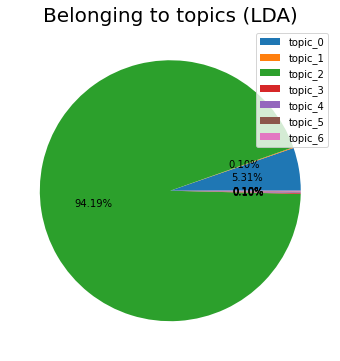

In [38]:
# Belonging to topics for first item
print(data['product_name'].iloc[0])
plot_LDA(text_LDA[0,:]);

In [39]:
# %%flake8  # checking PEP8 compliance

# Display shape of results
print(text_LDA.shape)

# Save the file (text type)
np.savetxt(save_dir + "features/text_LDA.csv", text_LDA)

(1050, 7)


## Option 4 : 'embedding' par réseau neuronal

In [40]:
!pip install --upgrade tensorflow-gpu
 #Install TF-Hub.
!pip install tensorflow-hub
!pip install seaborn

     |████████████████████████████████| 320.4MB 49kB/s 


In [41]:
import pandas as pd
import numpy as np
import re, string
import os 
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import linear_kernel

In [42]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [43]:
%time model = hub.load(module_url)#Create function for using model training

def embed(input):
    return model(input)

messages = list(data["descriptions"])
text_EMB = embed(messages)

CPU times: user 11.8 s, sys: 3.24 s, total: 15 s
Wall time: 15.6 s


In [44]:
messages = list(data["descriptions"])

In [45]:
text_EMB = embed(messages)

In [46]:
# %%flake8  # checking PEP8 compliance

# Display shape of results
print(text_EMB.shape)

# Save the file (text type)
np.savetxt(save_dir + "features/text_EMB.csv", text_EMB)

(1050, 512)


# Extraction de variables à partir des données visuelles

## Prétraitements : redimensionnement, contraste et luminosité…

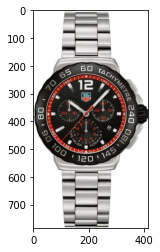

In [47]:
import cv2
import os
from matplotlib import pyplot as plt

# Get an exemple of image path
image_name = data['image'].loc[9]
dir_image = dir_name + 'Flipkart/Images'

file_path = os.path.join(dir_image, image_name)

# Read the file and convert it to color image
img = cv2.imread(file_path)
RGB_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display image
plt.imshow(RGB_im)

In [48]:
def resize_image(img, size, interpolation):
    """Function to resize image without deformation."""
    
    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]
    
    if h == w: return cv2.resize(img, (size, size), interpolation)
    if h > w: dif = h 
    else:     dif = w
        
    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)
    
    if c is None:
        # mask = np.zeros((dif, dif), dtype=img.dtype)
        mask = np.full((dif, dif), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        
    else:
        # mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask = np.full((dif, dif, c), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
        
    return cv2.resize(mask, (size, size), interpolation)

(224, 224, 3)


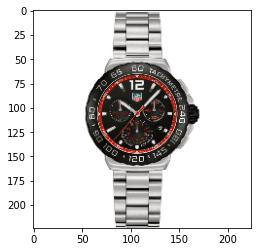

In [49]:
squared_image=resize_image(RGB_im, size=224, interpolation=cv2.INTER_AREA)
print(squared_image.shape)
plt.imshow(squared_image)

In [50]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)


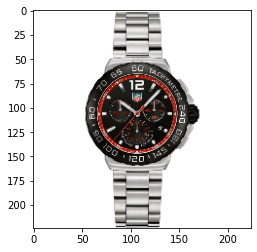

In [51]:
auto_result, alpha, beta = automatic_brightness_and_contrast(squared_image)
plt.imshow(auto_result)

In [52]:
import os
import cv2 # opencv library for computer vision

# initializations
dir_read = dir_name + 'Flipkart/Images'
dir_write = dir_name + 'Flipkart/preprocessed_images'

lst_img_path = []

# for each product in the data
for index, row in data.iterrows():
    
    # get url of the product's image
    img_name = row['image']
    
    # create the path to the image file
    img_path = os.path.join(dir_read, img_name)
    lst_img_path.append(img_path)
    
    # Read the file and convert it to color image
    img_file = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)
    
    # resize the image to 224*224 pixels
    img_sqr = resize_image(img_rgb, size=224, interpolation=cv2.INTER_AREA)
    
    # auto-adjustment of contrast and luminosity
    img_preprocessed, alpha, beta = automatic_brightness_and_contrast(img_sqr)
    
    # save the preprocessed image
    img_preprocessed_path = os.path.join(dir_write, img_name)
    cv2.imwrite(img_preprocessed_path, img_preprocessed)

In [53]:
from IPython.core.display import HTML
import cv2
import numpy as np
from matplotlib import pyplot as plt


#dir_name = '.\data\preprocessed_images'
dir_name_prepro = dir_name + 'Flipkart/preprocessed_images'
tags = []

# Getting the list of categories of product
categories_list = list(data['cat_1'].unique())

# Iterating over categories of products
for category in categories_list:
    print("Image in category :" + category)
    print("________________________________________________________")
    # Sampling n products belonging to the category
    mask = data['cat_1'] == category
    sample = data[mask].sample(n=15)
    
    # Iterating over each product in the sample
  
    for index, row in sample.iterrows():
        # getting the path of image
        img_name = row['image']
        img_path = os.path.join(dir_name_prepro, img_name)
        img = cv2.imread(img_path)
        img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_cvt)
        plt.show()
        
        # Create the html code for displaying the images
        tags.append('<img src="{}" width="50" style="display:inline"/>'.format(img_path))


Output hidden; open in https://colab.research.google.com to view.

In [54]:
from IPython.core.display import HTML
import cv2
import numpy as np
from matplotlib import pyplot as plt
import shutil


#dir_name = '.\data\preprocessed_images'
dir_name_prepro = dir_name + 'Flipkart/preprocessed_images'
tags = []

# Getting the list of categories of product
categories_list = list(data['cat_1'].unique())

# Iterating over categories of products
for category in categories_list:
    print("Image in category :" + category)
    print("________________________________________________________")
    # Sampling n products belonging to the category
    mask = data['cat_1'] == category
    sample = data[mask]
    
    # Iterating over each product in the sample
  
    for index, row in sample.iterrows():
        # getting the path of image
        img_name = row['image']
        img_path = os.path.join(dir_name_prepro, img_name)
        shutil.copy(img_path , dir_name_prepro +"/"+ category +"/" + img_name)
        #print(img_path)

Image in category :Home Furnishing
________________________________________________________
Image in category :Baby Care
________________________________________________________
Image in category :Watches
________________________________________________________
Image in category :Home Decor & Festive Needs
________________________________________________________
Image in category :Kitchen & Dining
________________________________________________________
Image in category :Beauty and Personal Care
________________________________________________________
Image in category :Computers
________________________________________________________


In [55]:
from IPython.core.display import HTML

#dir_name = '.\data\preprocessed_images'
dir_name_prepro = dir_name + 'Flipkart/preprocessed_images'
tags = []

# Getting the list of categories of product
categories_list = list(data['cat_1'].unique())

# Iterating over categories of products
for category in categories_list:
    
    # Sampling n products belonging to the category
    mask = data['cat_1'] == category
    sample = data[mask].sample(n=15)
    
    # Iterating over each product in the sample
    
    tags.append('<br><b>{}</b><br>'.format(category))
    for index, row in sample.iterrows():
        # getting the path of image
        img_name = row['image']
        img_path = os.path.join(dir_name_prepro, img_name)
        
        # Create the html code for displaying the images
        tags.append('<img src="{}" width="50" style="display:inline"/>'.format(img_path))

tags.append('<br>')
# Display the images of the category
HTML(''.join(tags))

### Sauvegarde liste image

In [56]:
import pickle
#save
with open(save_dir + "lst_img_path.txt", "wb") as fp:   #Pickling
   pickle.dump(lst_img_path, fp)


In [57]:
import pickle
#load
with open(save_dir + "lst_img_path.txt", "rb") as fp:   # Unpickling
   lst_img_path = pickle.load(fp)

len(lst_img_path)

1050

In [58]:
len(lst_img_path)

1050

## Option 1 : algorithme ORB

### Extraction des features et descripteurs

In [59]:
import cv2 # opencv library for computer vision

orb = cv2.ORB_create()
model = orb

In [60]:
"""
sift = cv2.xfeatures2d.SIFT_create()
model = sift

surf = cv2.xfeatures2d.SURF_create()
model = surf
"""

'\nsift = cv2.xfeatures2d.SIFT_create()\nmodel = sift\n\nsurf = cv2.xfeatures2d.SURF_create()\nmodel = surf\n'

In [61]:
def get_descriptors(image_path):
    
    # load image and convert it to grayscale
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # detect key points and descriptors
    keypoints, descriptors = model.detectAndCompute(img_gray, None)

    # returns keypoints and descriptors
    return keypoints, descriptors

(-0.5, 223.5, 223.5, -0.5)

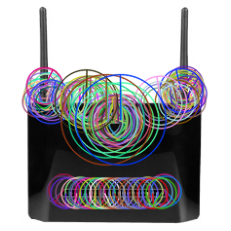

In [62]:
# get descriptors of the image
img_keypoints, img_descriptors = get_descriptors(img_path)

# get the image in gray
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gray)

# melt the image with keypoints
img_kp = cv2.drawKeypoints(
    image=img_gray,
    keypoints=img_keypoints,
    outImage=None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# show the grey image with keypoints
plt.imshow(img_kp)
plt.axis('off')

In [63]:
print("We get, for each image, {} keypoints and descriptors of {} dimensions."
      .format(img_descriptors.shape[0], img_descriptors.shape[1]))

We get, for each image, 123 keypoints and descriptors of 32 dimensions.


In [64]:
from PIL import Image
import os
import cv2 # opencv library for computer vision

# initializations
data.loc[:,'descriptors'] = pd.Series(index=data.index)
data['descriptors'] = data['descriptors'].astype(object)

# computing descriptors for each image of product
for index, row in data.iterrows():
    
    # get url of the product's image
    img_name = row['image']
    
    # create the path to the image file
    img_path = os.path.join(dir_name_prepro, img_name)
    
    # get the keypoints and descriptors of image
    img_keypoints, img_descriptors = get_descriptors(img_path)
    
    # add descriptors into a new column of the dataframe
    data.at[index, 'descriptors'] = img_descriptors

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


### Création "manuelle" des *bags-of-visual-words* (BoVW)

#### Aggrégation des descripteurs

In [65]:
# agregation of the descriptors of ALL images
for index, row in data.iterrows():
    if 'descriptors' not in globals():
        # creation of the agregation object for descriptors
        descriptors = row['descriptors']
    else:
        # to deal with the case where no descriptors were found
        if row['descriptors'] is not None:
            # concatenation of the descriptors
            descriptors = np.concatenate((descriptors, row['descriptors']), axis=0) 

print(descriptors.shape)

(378870, 32)


#### Sélection du nombre de '*visual words*'

In [66]:
# %%flake8  # checking PEP8 compliance

import numpy as np
from sklearn.base import BaseEstimator

class GridSearch(BaseEstimator):
    """Classe permettant d'implémenter une recherche exhaustive sur grille
    (sans validation croisée) pour les algorithmes de clustering."""

    # Method: init
    # ------------------------------------------------------------------------------
    def __init__(
            self,
            estimator,  # clustering algorithm to test
            param_grid,  # research space for hyperparameters
            scoring=None):
        """Méthode d'initialisation prenant en entrée le modèle
        à tester et la grille de paramètres."""

        # getting parameters
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring

    # Method: fit
    # ------------------------------------------------------------------------------
    def fit(self, X):
        """Méthode permettant de réaliser la recherche sur grille,
        et renvoyant le meilleur modèle trouvé, ré-entraîné sur les données."""

        # initialization of the dict of results
        self.results_ = {"scores": [],
                         "params": [],
                         "models": [],
                         "fit_times": [],
                         "nb_clusters": [],
                         "gini_coef": []}

        # Loading modules
        from sklearn.model_selection import ParameterGrid

        # iterating upon all combinations of parameters
        for param_combination in ParameterGrid(param_grid):

            # instanciation of the model with selected parameters
            model = self.estimator(**param_combination)

            # Measuring training time while fitting the model on the data
            time_train = %timeit -n1 -r1 -o -q model.fit(X)
            time_train = time_train.average

            # Scoring the model
            print(self.scoring)
            if not self.scoring:  # if scoring parameter not defined
                model_score = model.score(X)
            else:  # if scoring parameter is defined
                try:
                    labels = model.labels_
                    model_score = self.scoring(X, labels)
                except:
                    model_score = np.nan
            print(model_score)
            
            # Computing number of clusters, excluding noise (#-1)
            nb_clusters = \
                len(set(model.labels_)) - (1 if -1 in set(model.labels_) else 0)
            nb_clusters = int(nb_clusters)
            print(nb_clusters)

            # saving results, parameters and models in a dict
            self.results_["scores"].append(model_score)  # scores
            self.results_["params"].append(param_combination)  # parameters
            self.results_["models"].append(model)  # trained models
            self.results_["fit_times"].append(time_train)  # training time
            self.results_["nb_clusters"].append(nb_clusters)  # nb of clusters
        
        # Selecting best model (assumes that 'greater is better')
        # -----------------------------------
        best_model_index, best_score = None, None  # initialisation
        # iterating over scores
        for index, score in enumerate(self.results_["scores"]):

            # initialisation
            if not best_score:
                best_score = score
                best_model_index = index

            # if score is better than current best_score
            if score > best_score:
                # update the current best_score and current best_model_index
                best_score = score
                best_model_index = index
        
        # Update attributes of the instance
        self.best_score_ = self.results_["scores"][best_model_index]
        self.best_params_ = self.results_["params"][best_model_index]
        self.best_estimator_ = self.results_["models"][best_model_index]
        self.best_index_ = best_model_index
        self.refit_time_ = self.results_["fit_times"][best_model_index]

        return self

    # Method: predict
    # ------------------------------------------------------------------------------
    def predict(self, X_test):
        """Méthode permettant de réaliser les prédictions sur le jeu de test,
        en utilisant le meilleur modèle trouvé avec la méthode .fit
        entraîné sur le jeu d'entraînement complet."""

        # use the .predict method of the estimator on the best model
        return self.best_model.predict(X_test)

In [67]:
"""
%%capture
# %%flake8  # checking PEP8 compliance

# importing modules
from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score


# Definition of the search space for hyperparameters
param_grid = {
    "n_clusters": [100, 200, 500, 1000, 2000, 5000],  # vocabulary_size
}

# instanciation of the GridSearch object
kmeans_search = GridSearch(
    estimator=cluster.MiniBatchKMeans,
    param_grid=param_grid,
    scoring=silhouette_score,
    #scoring=calinski_harabasz_score,
)

# Proceeding the grid search
kmeans_search.fit(descriptors)

# Displays best parameters
print("Best hyperparameters:", kmeans_search.best_params_)
print("Best Silhouette score:", kmeans_search.best_score_)
print("Training time:", kmeans_search.refit_time_)
"""

'\n%%capture\n# %%flake8  # checking PEP8 compliance\n\n# importing modules\nfrom sklearn import cluster\nfrom sklearn.metrics import silhouette_score\nfrom sklearn.metrics import calinski_harabasz_score\n\n\n# Definition of the search space for hyperparameters\nparam_grid = {\n    "n_clusters": [100, 200, 500, 1000, 2000, 5000],  # vocabulary_size\n}\n\n# instanciation of the GridSearch object\nkmeans_search = GridSearch(\n    estimator=cluster.MiniBatchKMeans,\n    param_grid=param_grid,\n    scoring=silhouette_score,\n    #scoring=calinski_harabasz_score,\n)\n\n# Proceeding the grid search\nkmeans_search.fit(descriptors)\n\n# Displays best parameters\nprint("Best hyperparameters:", kmeans_search.best_params_)\nprint("Best Silhouette score:", kmeans_search.best_score_)\nprint("Training time:", kmeans_search.refit_time_)\n'

**Indice de Calinski-Harabasz** (Critère de rapport des variances)

Pour *k* groupes, l'indice *s* de Calinski-Harabasz est le rapport de la dispersion inter-groupes moyenne et de la dispersion intra-groupe :

$ s(k) = \frac{\mathrm{Tr}(B_k)}{\mathrm{Tr}(W_k)} \times \frac{N-k}{k-1}$

* où $B_k$ est la matrice de dispersion inter-groupes : $B_k = \sum\limits_{q=1}^k n_q(c_q-c)(c_q-c)^T$

* et $W_k$ est la matrice de dispersion intra-groupe : $W_k = \sum\limits_{q=1}^k \sum\limits_{x \in C_q} (x-c_q)(x-c_q)^T$

avec *N* le nombre de points de données, $C_q$ l'ensemble des points dans le groupe *q*, $c_q$ le centroïde du groupe *q*, c le centroïde du groupe *E* et $n_q$ le nombre de points dans le groupe *q*.

In [68]:
"""
# %%flake8  # checking PEP8 compliance

# Getting the list of parameters and list of scores
n_clusters_list = [kmeans_search.results_['params'][i]['n_clusters']
                   for i in range(len(kmeans_search.results_['params']))]
scores_list = kmeans_search.results_['scores']

# Plotting the influence of the single hyperparameter
plt.xlabel("n_clusters")
plt.ylabel("Calinski-Harabasz index\n(higher is better)")
plt.title("Influence de l'hyperparamètre : n_clusters")
plt.plot(n_clusters_list, scores_list);
"""

'\n#\xa0%%flake8  # checking PEP8 compliance\n\n# Getting the list of parameters and list of scores\nn_clusters_list = [kmeans_search.results_[\'params\'][i][\'n_clusters\']\n                   for i in range(len(kmeans_search.results_[\'params\']))]\nscores_list = kmeans_search.results_[\'scores\']\n\n# Plotting the influence of the single hyperparameter\nplt.xlabel("n_clusters")\nplt.ylabel("Calinski-Harabasz index\n(higher is better)")\nplt.title("Influence de l\'hyperparamètre :\xa0n_clusters")\nplt.plot(n_clusters_list, scores_list);\n'

#### Segmentation des descripteurs

In [69]:
from sklearn.cluster import MiniBatchKMeans

# set the size of the vocabulary of visual words
vocabulary_size = 1000

# instanciate a clustering model
kmeans = MiniBatchKMeans(
    n_clusters=vocabulary_size,
    random_state=seed,
    init_size=3000,
)

# apply the clustering model
kmeans.fit(descriptors)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=3000, max_iter=100, max_no_improvement=10,
                n_clusters=1000, n_init=3, random_state=638,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

#### Création des histogrammes ("bags-of-visual-words")

In [70]:
# initialization
data.loc[:,'visual_words'] = pd.Series(index=data.index)
data['visual_words'] = data['visual_words'].astype(object)

# for each image, convert descriptors into a list of visual words
for index, row in data.iterrows():
    if data.loc[index, 'descriptors'] is not None:
        visual_words_predict = list(kmeans.predict(data.loc[index, 'descriptors']))
    else:
        visual_words_predict = []
    # save the list of visual words
    data.at[index, 'visual_words'] = visual_words_predict

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [71]:
# %%flake8  # checking PEP8 compliance

# Convert the list to a DataFrame with relative frequencies
def frequency_encoding(dataframe, feature, prefix):

    # ---------------------------------------------------
    # Function to convert list of values to a value:frequency dict
    def list_to_dict(my_list):
        dictionnary = {}
        for item in my_list:
            if item not in dictionnary.keys():
                dictionnary[item] = 1
            else:
                dictionnary[item] += 1
        return dictionnary
    
    # ------------------------------------------------
    # Function to FrequencyVectorize a dictionnary
    def frequency_encoding_from_dict(dictionnary):
        frequencies = pd.Series()
        total_frequency = sum(dictionnary.values())

        for key, value in dictionnary.items():
            frequencies[prefix + str(key)] = value / total_frequency

        return frequencies

    # ------------------------------------------------
    # Convert lists to dictionnary
    dataframe[feature] = dataframe[feature].apply(list_to_dict)

    # Proceed to the frequency encoding
    frequency_df = dataframe[feature]\
        .apply(frequency_encoding_from_dict).fillna(0)

    # Return the frequency_encoding pd.DataFrame
    return frequency_df

In [72]:
# frequency encoding of bags-of-visual-words
img_BOVW = frequency_encoding(data, 'visual_words', 'vw_')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [73]:
# %%flake8  # checking PEP8 compliance

# Save the file (text type)
np.savetxt(save_dir + "features/img_BOVW.csv", img_BOVW)

## Option 2 : extraction des features par CNN

### Récupération de la base convolutionnelle

In [74]:
%%capture --no-stdout 

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [75]:
%%capture

from keras import applications

# getting the convolutional base of a ResNet50 CNN
conv_base = applications.resnet50.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

### Ajout d'une couche 'GlobalMaxPooling' ou 'Flatten'
Pour réduction dimensionnelle et applatissement des tenseurs

In [76]:
# %%capture --no-stdout

from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D
from keras.layers import Flatten

# use the sequential API to use the .add method
cnn_model = Sequential()
cnn_model.add(conv_base)

# add layer for dimensional reduction and flattening
# cnn_model.add(GlobalMaxPooling2D())
cnn_model.add(Flatten())

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


### Extraction des features

In [77]:
import cv2
import os
import numpy as np


# for each product
for img_file_name in data['image']:
    
    # get the file path of the image
    file_path = os.path.join(dir_name_prepro, img_file_name)
    
    # open the image as a np.ndarray
    img = cv2.imread(file_path)
    
    # reshape img to get a tensor
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    
    # get the features extracted from the convolutional base
    features_img = cnn_model.predict(img)

    # check if 'img_CNN' already exists or not
    if 'img_CNN' not in locals():
        # create the features_cnn variable
        img_CNN = features_img
        
    else:
        # concatenate the features_img to features_cnn
        img_CNN = np.concatenate((features_img, img_CNN), axis=0)

In [78]:
# %%flake8  # checking PEP8 compliance

print("Shape of the features ndarray from CNN:", img_CNN.shape)

# Save the file (text type)
np.savetxt(save_dir + "features/img_CNN.csv", img_CNN)


Shape of the features ndarray from CNN: (1050, 100352)


### Réduction dimensionnelle par NMF

In [79]:
from sklearn.decomposition import NMF

model = NMF(n_components=7, random_state=seed)
img_CNN_nmf = model.fit_transform(img_CNN)

print("Shape of the features ndarray from CNN after NMF reduction:", img_CNN_nmf.shape)

# Save the file (text type)
np.savetxt(save_dir + "features/img_CNN_nmf.csv", img_CNN_nmf)

Shape of the features ndarray from CNN after NMF reduction: (1050, 7)


# Segmentation des produits

## Chargement des variables standardisées

In [80]:
# loading features from textual fields
text_TFIDF = np.loadtxt(open(save_dir + "features/text_TFIDF.csv", "rb"))
text_NMF = np.loadtxt(open(save_dir + "features/text_NMF.csv", "rb"))
text_LDA = np.loadtxt(open(save_dir + "features/text_LDA.csv", "rb"))
text_EMB = np.loadtxt(open(save_dir + "features/text_EMB.csv", "rb"))

# loading features from image
img_BOVW = np.loadtxt(open(save_dir + "features/img_BOVW.csv", "rb"))
img_CNN = np.loadtxt(open(save_dir + "features/img_CNN.csv", "rb"))
img_CNN_nmf = np.loadtxt(open(save_dir + "features/img_CNN_nmf.csv", "rb"))

In [81]:
from sklearn.preprocessing import StandardScaler

# Apply the standard scaler to the TF-IDF features
text_TFIDF_std = StandardScaler().fit_transform(text_TFIDF)

# Apply the standard scaler to the TF-IDF features
text_EMB_std = StandardScaler().fit_transform(text_EMB)

# Apply the standard scaler to the Bags-of-features
img_BOVW_std = StandardScaler().fit_transform(img_BOVW)

# Apply the standard scaler to the features extracted from CNN
img_CNN_std = StandardScaler().fit_transform(img_CNN)

## Réduction de dimensions (par ACP)

In [82]:
#-----------------------------------------------------------------------
def PCA_features_reduction(X_std, var_threshold=0.9, verbose=True):
    """Return the principal components from PCA, until variance threshold."""

    from sklearn import decomposition
    
    if verbose == True:
        print("Initial number of features:", X_std.shape[1])
    
    # Processing the PCA
    pca = decomposition.PCA()
    pca.fit(X_std)
    
    # Getting the explained variance ratio for each principal component
    scree = pca.explained_variance_ratio_

    # Getting the number of principal components to reach variance thresholds
    mask = scree.cumsum() > var_threshold
    nb_selected_features = len(scree[~mask]) + 1
    if verbose == True:
        print("Number of selected features:", nb_selected_features)
    
    # Compute and displays the actual ratio of explained variance
    explained_variance_sum = scree.cumsum()[nb_selected_features-1]
    if verbose == True:
        print("Cumulative explained variance:  {:.2f}%".format(explained_variance_sum*100))
    
    # Getting the projection of the data on the first components
    X_projected = pca.transform(X_std)[:,:nb_selected_features]
    
    return X_projected

In [83]:
# Applying dimensional reduction (PCA)
text_EMB_pca = PCA_features_reduction(text_EMB_std, var_threshold=0.9)
print('--')
img_BOVW_pca = PCA_features_reduction(img_BOVW_std, var_threshold=0.9)
print('--')
img_CNN_pca = PCA_features_reduction(img_CNN_std, var_threshold=0.9)

Initial number of features: 512
Number of selected features: 137
Cumulative explained variance:  90.01%
--
Initial number of features: 1000
Number of selected features: 465
Cumulative explained variance:  90.03%
--
Initial number of features: 100352
Number of selected features: 687
Cumulative explained variance:  90.02%


## Réduction de dimensions (par NMF)

In [84]:
#data_features_list = {'text_TFIDF':text_TFIDF, 'text_EMB':text_EMB, 'img_BOVW':img_BOVW, 'img_CNN':img_CNN}
data_features_list = {'text_TFIDF':text_TFIDF, 'img_CNN':img_CNN}

# checking that the features are 'non-negative'
for key, value in data_features_list.items():
    print("All values are positive or null in {}: {}"
          .format(key, (value >= 0).all()))

All values are positive or null in text_TFIDF: True
All values are positive or null in img_CNN: True


In [85]:
def log_range(start, end, n_steps, integer=False):
    """Return a list of numbers from start to end in a logarithmic fashion."""
    
    # compute the base to use
    base = (end/start)**(1/(n_steps-1))
    
    # compute the list of values
    values = []
    for k in range(n_steps):
        # compute the value
        value = start*(base**k)
        
        # convert to integer if required
        if integer == True:
            value = int(value)
        
        # add the value to the list
        values.append(value)
    
    return values

In [86]:
"""
import matplotlib.ticker as ticker

x_plot = log_range(start=1, end=X.shape[0]/2, n_steps=4, integer=True)
y_plot = scores / scores[0]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x_plot, y_plot)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

plt.ylim(0, 1.01);
"""

'\nimport matplotlib.ticker as ticker\n\nx_plot = log_range(start=1, end=X.shape[0]/2, n_steps=4, integer=True)\ny_plot = scores / scores[0]\n\nfig, ax = plt.subplots(figsize=(20, 10))\nax.plot(x_plot, y_plot)\nax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))\n\nplt.ylim(0, 1.01);\n'

In [87]:
def make_positive(matrix):
    """Convert a np.ndarray to a positive one
    (eg preprocessing for NMF)."""
    
    if (matrix >= 0).all():
        return matrix
    
    def make_positive_col(col):
        col_min = np.min(col)
        if col_min < 0:
            positive_col = col - col_min
            return positive_col
        elif col_min >= 0:
            return col
    
    positive_mat = np.apply_along_axis(make_positive_col, axis=1, arr=matrix)
    return positive_mat

In [88]:
from sklearn.decomposition import NMF

text_EMB_positive = make_positive(text_EMB)
model = NMF(n_components=7, random_state=seed)
text_EMB_nmf = model.fit_transform(text_EMB_positive)

In [89]:
from sklearn.preprocessing import StandardScaler

# Apply the standard scaler to the features
text_EMB_nmf = StandardScaler().fit_transform(text_EMB_nmf)

## Évaluation des segmentations

**Indice de Rand Ajusté** (ARI)
L'*Adjusted Rand Index* (ARI) est la normalisation de RI qui permet de comparer deux partitions de nombres de classes différentes.

$ ARI = \frac{RI-E(RI)}{max(RI)-E(RI)}$
* RI : indice de Rand : proportion de paires de points qui sont groupés de la même façon dans les deux partitions.
* E(RI) : espérance de l'indice de Rand (pour une partition aléatoire)
* max(RI) : indice de Rand maximal qui pourrait être obtenu étant donné le nombre de classes distincts.

In [90]:
from sklearn.metrics.cluster import adjusted_rand_score
import statistics

def evaluate_clusterings(features_std, nb_iter=5):
    
    # initializations
    labels_true = data['cat_1']
    ARI_list = []

    # iterating for robustness of measures
    for i in range(nb_iter):
        
        # fitting the model
        kmeans.fit(features_std)

        # getting the predicted labels
        labels_pred = kmeans.labels_

        # computing the ARI score
        ARI_score= adjusted_rand_score(labels_true, labels_pred)

        # appending the ARI score
        ARI_list.append(ARI_score)

    # Compute the mean and standard deviation of ARI scores
    ARI_mean = statistics.mean(ARI_list)
    ARI_std = statistics.stdev(ARI_list)
    
    # returning mean and standard deviation of ARI scores
    return ARI_mean, ARI_std

In [91]:
from sklearn import cluster

# kmeans model with as much clusters as categories
kmeans = cluster.MiniBatchKMeans(
    n_clusters=7, # main categories of products
    # random_state=seed, # for reproductibility
)

In [92]:
import itertools

text_features_dict = {
    'text_TFIDF':text_TFIDF_std,
    'text_NMF': text_NMF,
    'text_LDA': text_LDA,
    'text_EMB_pca': text_EMB_pca,
    'text_EMB_nmf': text_EMB_nmf,
    'None':None,
}

img_features_dict = {
    'img_BOVW':img_BOVW_pca,
    'img_CNN_pca': img_CNN_pca,
    'img_CNN_nmf': img_CNN_nmf,
    'None':None,
}
results_df = pd.DataFrame()

for feats in itertools.product(text_features_dict, img_features_dict):
    if (feats[0] is not 'None') or (feats[1] is not 'None'):
        if feats[0] is 'None':
            name = feats[1]
            features_std = img_features_dict[feats[1]]
        elif feats[1] is 'None':
            name = feats[0]
            features_std = text_features_dict[feats[0]]
        else:
            # concatenate the features from description and features from image
            name = feats[0] + ' +\n' + feats[1]
            features_std = np.concatenate((text_features_dict[feats[0]], img_features_dict[feats[1]]) , axis=1)
            
        # computing the mean and standard deviation for ARI scores
        ARI_mean, ARI_std = evaluate_clusterings(features_std, nb_iter=10)
        
        # create the name for further plotting
        results_df.loc[name, 'ARI mean'] = ARI_mean
        results_df.loc[name, 'ARI std'] = ARI_std
        
# print results
results_df

,ARI mean,ARI std
text_TFIDF +\nimg_BOVW,0.008824,0.013838
text_TFIDF +\nimg_CNN_pca,0.006752,0.003291
text_TFIDF +\nimg_CNN_nmf,0.005961,0.013753
text_TFIDF,0.014423,0.026724
text_NMF +\nimg_BOVW,0.017705,0.006500
text_NMF +\nimg_CNN_pca,0.006544,0.003616
text_NMF +\nimg_CNN_nmf,0.020342,0.001781
text_NMF,0.222282,0.010101
text_LDA +\nimg_BOVW,0.016001,0.007197
text_LDA +\nimg_CNN_pca,0.005879,0.003922


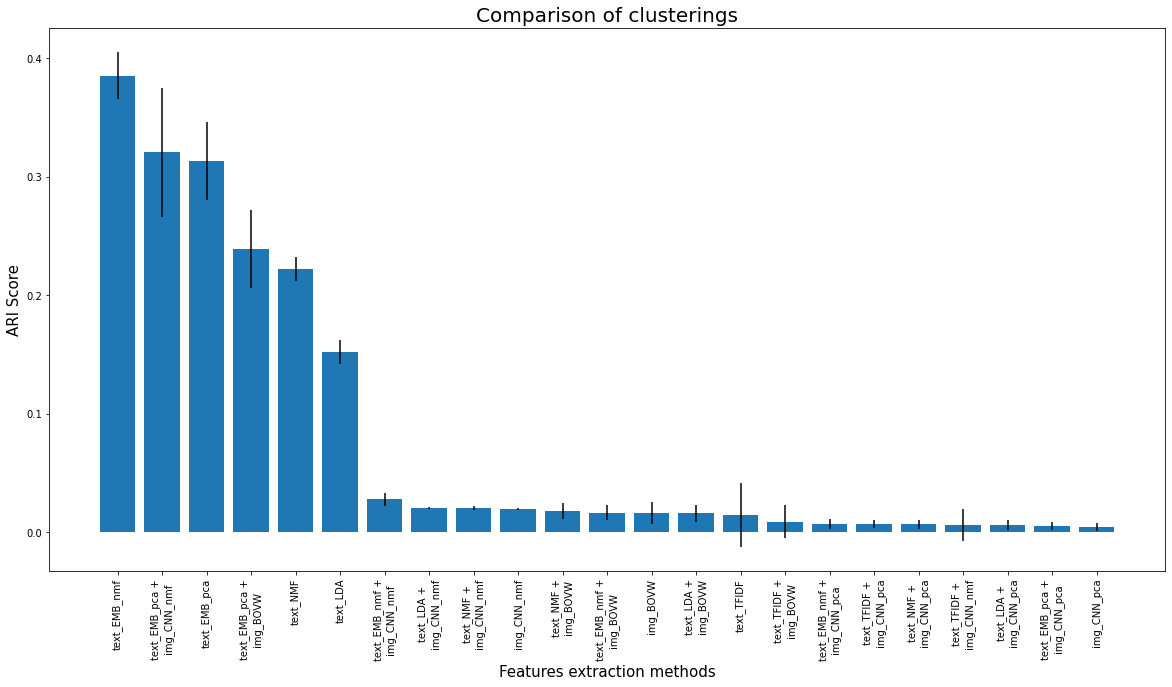

Best ARI results: 38.5%  ± 2.0% with text_EMB_nmf.


In [93]:
ind = np.arange(len(results_df))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

results_df = results_df.sort_values(by='ARI mean', ascending=False)
means = results_df['ARI mean']
std_errors = results_df['ARI std']
x_labels = list(results_df.index)

plt.figure(figsize=(20,10))
plt.bar(ind, means, yerr=std_errors)
plt.ylabel('ARI Score', size=15)
plt.xlabel('Features extraction methods', size=15)
plt.title('Comparison of clusterings', size=20)
plt.xticks(ind, x_labels)
plt.xticks(rotation='90', horizontalalignment="center")

plt.show()

print("Best ARI results: {:.1f}%  ± {:.1f}% with {}.".format(
    100*results_df['ARI mean'].iloc[0],
    100*results_df['ARI std'].iloc[0],
    results_df.index[0]
))

## Projection plane par t-SNE
Avec coloration des points en fonction de la catégorie de produit et glyphe en fonction du cluster ?

In [122]:
def tSNE_plot(features_std, target, random_state=None):
    """Compute the tSNE. Displays the embedding on 2 dimensions."""
    
    target_name = target.name
    y = target
    
    # Applying the t-SNE
    #-------------------
    # Import libraries
    from sklearn import manifold

    # Instanciation of t-SNE
    tsne = manifold.TSNE(n_components=2, # projection in a plane
                         perplexity=30,
                         n_iter=300,
                         init='pca', # initialisation by a PCA
                         random_state=random_state
                        )

    # Applying the t-SNE
    features_projected = tsne.fit_transform(features_std) # t-SNE do not have ".transform" method

    # Plotting the t-SNE embedding
    #-----------------------------
    fig = plt.figure(figsize=(12,7))

    # Definitions of axis boundaries
    plt.xlim(features_projected[:,0].min()*1.1, features_projected[:,0].max()*1.1)
    plt.ylim(features_projected[:,1].min()*1.1, features_projected[:,1].max()*1.1)

    # Definition of axis'labels
    plt.title("t-SNE\n", fontsize=20)
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    
    # For each category in the target
    for i, category in enumerate(y.unique()):
        mask = (y == category)
        features_subset = features_projected[mask]
        
        # Plotting the points of the category
        sc = plt.scatter(
            features_subset[:,0], # x-coordinate
            features_subset[:,1], # y-coordinate
            cmap=plt.cm.get_cmap('RdYlGn_r'), # colormap
            label=category
        )
    
    # Setting the legend   
    plt.legend()
    return fig

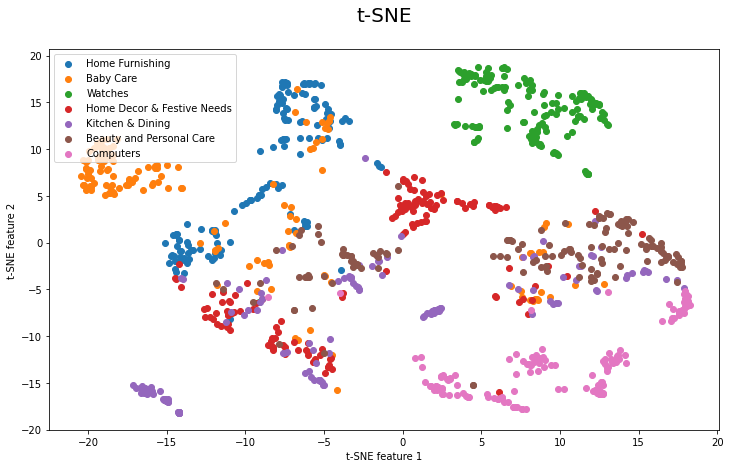

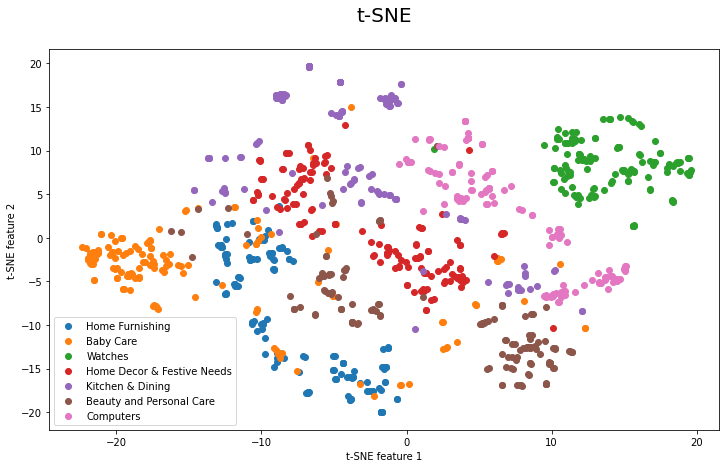

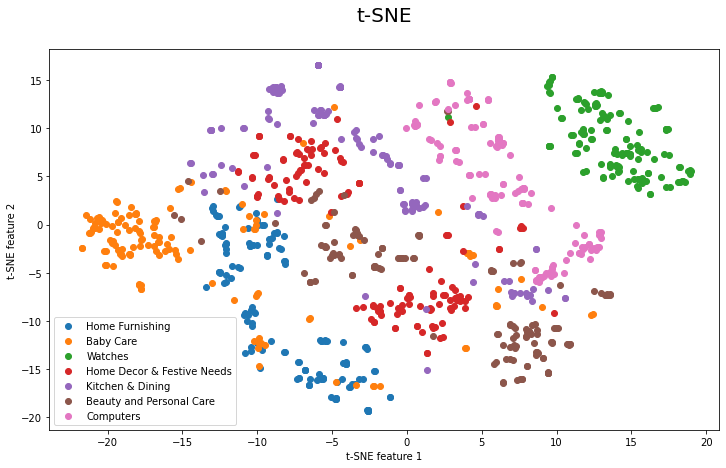

In [130]:
y = data['cat_1']
X_std = text_EMB_nmf
fig = tSNE_plot(X_std, y)
fig = tSNE_plot(text_EMB_pca, y)
X_std = np.concatenate((text_EMB_std, img_CNN_nmf) , axis=1)
fig = tSNE_plot(X_std, y)


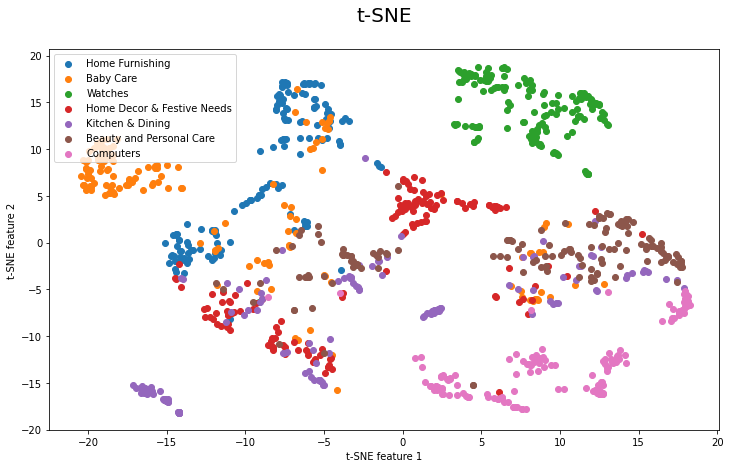

In [133]:
y = data['cat_1']
X_std = text_EMB_nmf


fig = tSNE_plot(X_std, y)
fig.savefig(save_dir + 'plot/tSNE.png')

## Matrice de confusion

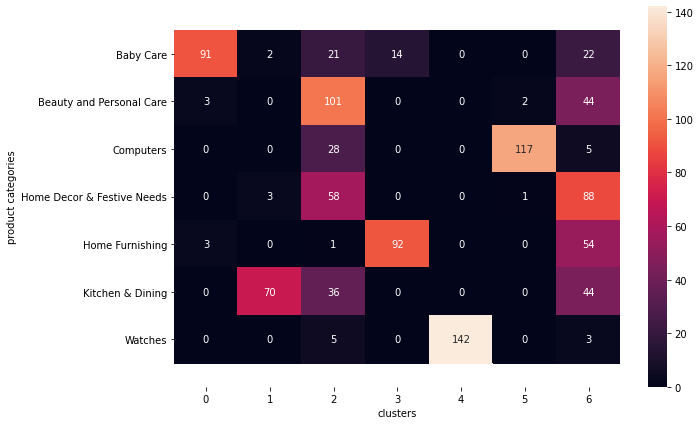

In [131]:
import seaborn as sn
import matplotlib.pyplot as plt

# Setting the variables to keep
features_std =  text_EMB_nmf

# fitting the model
kmeans.fit(features_std)

# getting the predicted labels
labels_pred = kmeans.labels_

# Create crosstab: ct
ct = pd.crosstab(data['cat_1'], labels_pred)

# plot the heatmap
plt.figure(figsize = (10,7))
ax = sn.heatmap(ct, annot=True, fmt='g')
ax.set_xlabel('clusters')
ax.set_ylabel('product categories')

# fix a displaying problem
ax.set_ylim(ax.get_ylim()[0]+0.5, ax.get_ylim()[1]-0.5);

## Classification

In [134]:
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Definition of the search space for hyperparameters
param_grid = {
    "n_neighbors":  range(2, 11),  # number of clusters
}

# Instanciation
knn = KNeighborsClassifier()
# X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=seed)

knn_gsCV = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, iid=False)

knn_gsCV.fit(features_std, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=False, n_jobs=-1, param_grid={'n_neighbors': range(2, 11)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Best model ('n_neighbors' = 7) has a mean accuracy of 83.5%.


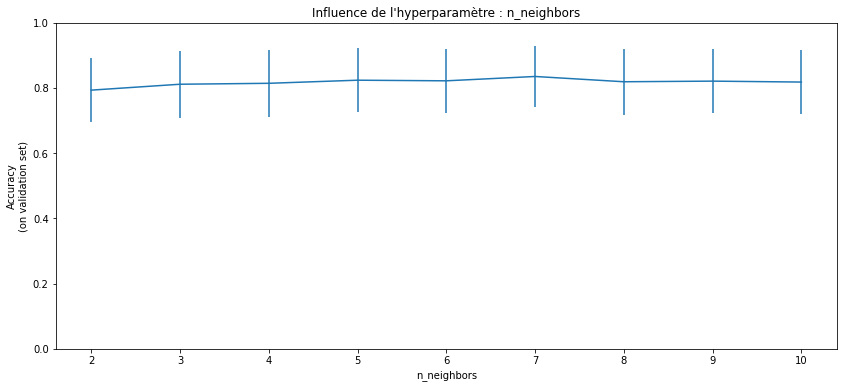

In [135]:
# %%flake8  # checking PEP8 compliance

# Getting the list of parameters and list of scores
n_neighbors_list = [knn_gsCV.cv_results_['params'][i]['n_neighbors']
                   for i in range(len(knn_gsCV.cv_results_['params']))]
scores_means = knn_gsCV.cv_results_['mean_test_score']
scores_std = knn_gsCV.cv_results_['std_test_score']

# Plotting the influence of the single hyperparameter

fig = plt.figure(figsize=(14, 6))
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy\n(on validation set)")
plt.title("Influence de l'hyperparamètre : n_neighbors")
plt.errorbar(n_neighbors_list, scores_means, yerr=scores_std)
plt.ylim([0,1])
plt.plot();
fig.savefig(save_dir + 'plot/knn_accuracy.png')


print("Best model ('n_neighbors' = {}) has a mean accuracy of {:.1f}%.".format(knn_gsCV.best_params_['n_neighbors'], 100*knn_gsCV.best_score_))